# Tutorial: Training Neural Networks with Sparse Input Decision Using Jacobinet
This tutorial provides a step-by-step guide to building and training a neural network with sparse input decision support using the *Jacobinet* library, which is built on top of Keras. We will explore key concepts, implement the neural network, train it, and visualize the sparsity of the gradient to understand its implications for robustness and interpretability.

- When running this notebook on Colab, we need to install *decomon* if on Colab. 
- If you run this notebook locally, do it inside the environment in which you [installed *jacobinet*](https://ducoffeM.github.io/jacobinet/main/install.html).

In [ ]:
# On Colab: install the library
on_colab = "google.colab" in str(get_ipython())
if on_colab:
    import sys  # noqa: avoid having this import removed by pycln

    # install dev version for dev doc, or release version for release doc
    !{sys.executable} -m pip install -U pip
    !{sys.executable} -m pip install git+https://github.com/ducoffeM/jacobinet@main#egg=decomon
    # install desired backend (by default torch)
    !{sys.executable} -m pip install "torch"
    !{sys.executable} -m pip install "keras"

    # extra librabry used in this notebook
    !{sys.executable} -m pip install "numpy"
    !{sys.executable} -m pip install "matplotlib"
    # missing imports IPython
    

## 1. Why Sparse Support is Useful
Before diving into the code, let’s understand why sparse support matters.

- Robustness: Sparse gradients focus only on the most important features of the input, ignoring irrelevant noise. This makes the network less sensitive to small perturbations or adversarial attacks.
- Interpretability: Sparse gradients help identify which parts of the input are the most influential in making a decision. This enhances the model's interpretability, as we can visualize which pixels (in image classification) contribute the most to predictions.


These two properties are crucial in high-stakes applications like healthcare, finance, and autonomous systems, where robustness and explainability are essential.

### Prerequisites

In [1]:
# !pip install keras jacobinet numpy matplotlib
# warning for mac users if .fit raise an error set the environment variable PYTORCH_ENABLE_MPS_FALLBACK=1

## 3. Loading and Preprocessing the Data
We will use the MNIST dataset, a collection of 28x28 grayscale handwritten digit images. Here, we load and preprocess the data.

In [2]:
import keras
import numpy as np

# Load the MNIST data and split it into training and testing sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale the images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Reshape images to have an additional channel dimension (1, 28, 28)
x_train = np.expand_dims(x_train, 1)
x_test = np.expand_dims(x_test, 1)

# Convert class labels to one-hot encoded vectors
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


/Users/ducoffe_m/Library/Python/3.9/lib/python/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/Users/ducoffe_m/Library/Python/3.9/lib/python/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


### Explanation:

The MNIST data is scaled to the range [0,1] to normalize pixel values.
We expand the dimensions to (1, 28, 28) to match the input shape required for a convolutional neural network (CNN).
Labels are converted to one-hot vectors for classification.

## 4. Building the Neural Network
We define a CNN using Keras Sequential API.



In [3]:
from keras import layers, Sequential

# Define the model architecture
model = Sequential(
    [
        layers.Input(shape=(1, 28, 28)),
        layers.Conv2D(32, kernel_size=(3, 3)),
        layers.Activation(activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3)),
        layers.Activation(activation="relu"),
        #layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(10)
    ]
)



model.summary()

train_model = Sequential(model.layers+[layers.Activation('softmax')])
train_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
train_model.fit(x_train, y_train, batch_size=128, epochs=1, validation_split=0.1)




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 26, 26)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 26, 26)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 13, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 11, 11)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 11, 11)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        77,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,266 (376.04 KB)

 Trainable params: 96,266 (376.04 KB)

 Non-trainable params: 0 (0.00 B)

  5/422 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.2038 - loss: 2.2557

/Users/ducoffe_m/Library/Python/3.9/lib/python/site-packages/keras/src/backend/torch/optimizers/torch_adam.py:35: UserWarning: The operator 'aten::_foreach_mul_.Scalar' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  torch._foreach_mul_(m_list, self.beta_1)


422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.8595 - loss: 0.5029 - val_accuracy: 0.9822 - val_loss: 0.0674


### Explanation:

Convolutional layers extract patterns from images using filters.
MaxPooling layers reduce spatial dimensions, making computation more efficient.
Flatten layer transforms the 2D feature maps into a 1D vector.
Dense layer produces 10 outputs, one for each digit class.

## 5. Introducing Jacobinet for Sparse Gradients
Here, we use Jacobinet to compute and constraint the sparsity of the gradient.

In [9]:
import keras.ops as K

# keeping the k lowest absolute value
class Keep_K_LowestValues(layers.Layer):
    def __init__(self, cardinality=1, **kwargs):
        super(Keep_K_LowestValues, self).__init__(**kwargs)
        self.cardinality = keras.Variable(cardinality, trainable=False)

    def call(self, inputs_):
        inputs_ = K.sort(K.abs(K.reshape(inputs_, (-1, 784))), axis=-1)
        outputs = inputs_[:, :K.cast(self.cardinality, 'int')]
        return outputs

    def compute_input_shape(input_shape):
        return (1, self.cardinality)

In [10]:
import jacobinet
from jacobinet import clone_to_backward
import keras.ops as K

# Create the backward model to compute gradients w.r.t input
backward_model = clone_to_backward(model)

# Inputs for images and labels
data = layers.Input((1, 28, 28))
label = layers.Input((10,))

gradient = backward_model([data, label])
layer_cut = Keep_K_LowestValues(cardinality=50)
cut_gradient = layer_cut(gradient)
sparse_gradient = K.sum(cut_gradient, axis=-1)
max_gradient = K.max(cut_gradient, axis=-1)

# New model to optimize both accuracy and gradient sparsity
new_model = keras.models.Model([data, label], [layers.Activation('softmax')(model(data)), sparse_gradient, max_gradient])


We create a Keras callback that gradually increases the number of zero components enforced on the input gradient throughout the training process.

In [11]:
from keras.callbacks import Callback

class SparsityConstraint(Callback):
    def __init__(self, cardinality, inc, max_sparsity_support):
        self.cardinality = cardinality
        self.inc = inc
        self.max_sparsity_support = max_sparsity_support

    def on_epoch_end(self, epoch, logs=None):
        if epoch%3==0 and epoch:
            new_value = np.minimum(self.cardinality.numpy() + self.inc, self.max_sparsity_support)
            self.cardinality.assign(new_value)


sparse_callback = SparsityConstraint(layer_cut.cardinality, 100, 500)

In [12]:
# Compile with combined losses (accuracy + gradient sparsity constraints)
new_model.compile(loss=["categorical_crossentropy", 'mse', 'mse'], optimizer="adam", 
                  metrics=["accuracy", "mse", "mse"], loss_weights=[1, 100, 1000])

In [13]:
# Train the model
new_model.fit([x_train, y_train], [y_train, 0*y_train[:, 1], 0*y_train[:, 1]], 
              batch_size=128, epochs=20, validation_split=0.1,
              callbacks=[sparse_callback])


Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - activation_3_accuracy: 0.9781 - activation_3_loss: 0.0744 - loss: 0.0745 - max_loss: 3.9071e-08 - max_mse: 3.9071e-08 - sum_loss: 1.1971e-06 - sum_mse: 1.1971e-06 - val_activation_3_accuracy: 0.9870 - val_activation_3_loss: 0.0512 - val_loss: 0.0514 - val_max_loss: 5.0120e-08 - val_max_mse: 5.0076e-08 - val_sum_loss: 1.6665e-06 - val_sum_mse: 1.6636e-06
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - activation_3_accuracy: 0.9857 - activation_3_loss: 0.0464 - loss: 0.0467 - max_loss: 5.5738e-08 - max_mse: 5.5738e-08 - sum_loss: 1.6855e-06 - sum_mse: 1.6855e-06 - val_activation_3_accuracy: 0.9870 - val_activation_3_loss: 0.0438 - val_loss: 0.0440 - val_max_loss: 4.6426e-08 - val_max_mse: 4.6403e-08 - val_sum_loss: 1.7423e-06 - val_sum_mse: 1.7400e-06
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - activation_3_accuracy: 0.9901 - activation_3_loss: 0.0332 - loss: 0.0334 - max_loss: 5.9856e-08 - max_mse: 5.9856e-08 - 

### Explanation:

Backward gradients: Jacobinet computes the gradient of the model's output w.r.t the input.
Sparse constraint: We retain only the lowest 400 elements in the gradient, considering absolute value 
to enforce sparsity on.
Multi-objective training: The loss is a combination of cross-entropy (for classification) and sparsity loss (to promote sparse gradients).

In [14]:
new_model.evaluate([x_train, y_train], [y_train, 0*y_train[:, :1], 0*y_train[:, :1]])

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 25ms/step - activation_3_accuracy: 0.9796 - activation_3_loss: 0.0684 - loss: 0.0697 - max_loss: 7.3259e-09 - max_mse: 7.3259e-09 - sum_loss: 1.3556e-05 - sum_mse: 1.3556e-05


[0.0704539567232132,
 0.06908426433801651,
 1.362367947876919e-05,
 7.434201254596928e-09,
 0.9789999723434448,
 7.434201254596928e-09,
 1.362367947876919e-05]

## 6. Visualizing Gradient Sparsity
After training, we visualize which parts of the image influence predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
7 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


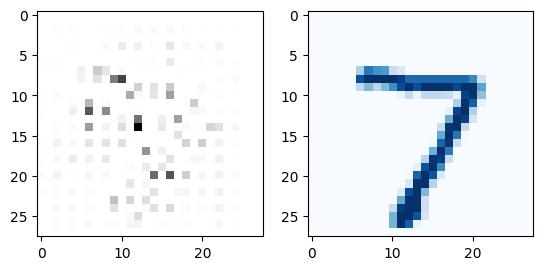

In [15]:
import matplotlib.pyplot as plt

index = 0
print(model.predict(x_test[index:index+1])[0].argmax(), y_test[index].argmax())
img_saliency = backward_model.predict([x_test[index:index+1], y_test[index:index+1]])

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.clip(np.abs(img_saliency[0,0]), 1e-7, 100), cmap='Grays')
ax2.imshow(x_test[index,0], cmap='Blues')
plt.show()


### Explanation:

The **saliency map** shows which pixels influence the network's prediction.
Sparse gradients result in cleaner and more interpretable saliency maps

## 7. Evaluating the Model
Finally, we evaluate the model's accuracy on the test set.

In [16]:
model.compile(loss=keras.metrics.CategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])

score = model.evaluate(x_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9692 - loss: 0.0912
Test loss: 0.09144507348537445
Test accuracy: 0.975600004196167


Text(0.5, 1.0, 'Distribution of absolute value of the gradient along the pixels')

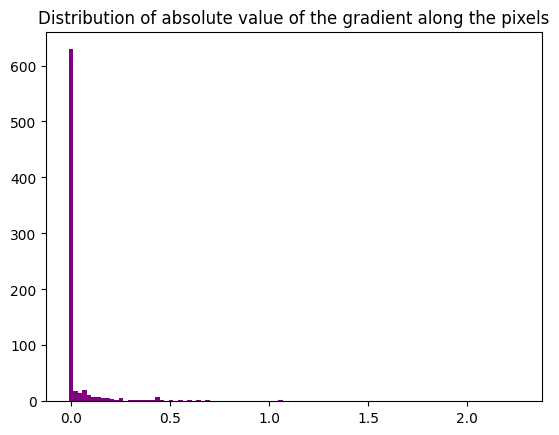

In [17]:
# histogram for the value
gradient_value = np.abs(np.reshape(img_saliency, (784,)))
bins = np.linspace(gradient_value.min(), gradient_value.max(), 100)
counts, _ =  np.histogram(gradient_value, bins=bins)
plt.bar(bins[:-1], counts, width=np.diff(bins), color='purple', label='Correct')
plt.title('Distribution of absolute value of the gradient along the pixels')

This step reports the test accuracy, which tells us how well the model generalizes to new data.

8. Analyzing Gradient Sparsity
We compute sparsity metrics for every image in the test set.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


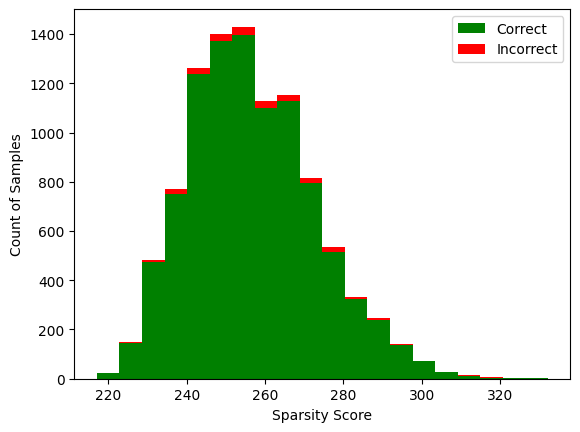

In [18]:
gradient_saliency = backward_model.predict([x_test, y_test], verbose=0)
sparsity_scores = (np.reshape(np.abs(gradient_saliency), (-1, 784)) > 1e-4).sum(-1)

# Separate the sparsity scores for correct and incorrect predictions
good_prediction = np.argmax(model.predict(x_test), -1) == np.argmax(y_test, -1)

# Plot histogram of sparsity scores
n_bins = 20
bins = np.linspace(sparsity_scores.min(), sparsity_scores.max(), n_bins + 1)

pos_counts, _ = np.histogram(sparsity_scores[good_prediction], bins=bins)
neg_counts, _ = np.histogram(sparsity_scores[~good_prediction], bins=bins)

plt.bar(bins[:-1], pos_counts, width=np.diff(bins), color='green', label='Correct')
plt.bar(bins[:-1], neg_counts, width=np.diff(bins), bottom=pos_counts, color='red', label='Incorrect')
plt.xlabel('Sparsity Score')
plt.ylabel('Count of Samples')
plt.legend()
plt.show()


### Explanation:

Sparsity score is the number of non-zero elements in the gradient.
We visualize how sparsity correlates with prediction success.


Plot a Heatmap of Sparsity Across All Test Samples
You can visualize how sparsity varies across all test samples, showing which samples were harder for the model to interpret

Shared zero gradient support across all the class 187


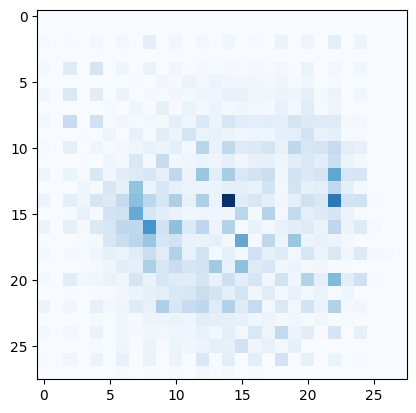

In [21]:
#select a label
class_label = 0
index_label = np.where(np.argmax(y_test, -1)==class_label)[0]
gradient_class = gradient_saliency[index_label]

average_img = np.mean(np.abs(gradient_class), axis=0)

epsilon_grad = 1e-4

print("Shared zero gradient support across all the class",  len(np.where(average_img.flatten()<epsilon_grad)[0]))

plt.imshow(average_img[0], cmap='Blues')

Shared zero gradient support across all the class 187


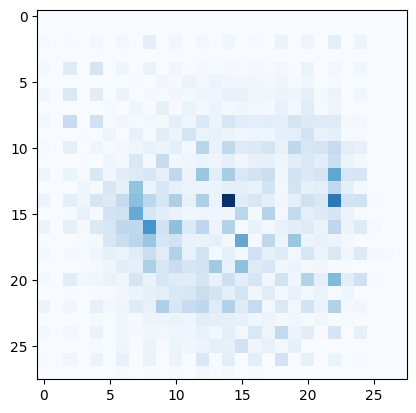

In [22]:
gradient_all = gradient_saliency[index_label]

average_img_all_class = np.mean(np.abs(gradient_all), axis=0)

print("Shared zero gradient support across all the class",  len(np.where(average_img_all_class.flatten()<epsilon_grad)[0]))

plt.imshow(average_img_all_class[0], cmap='Blues')

## 9. Baseline Comparison

Next we made an ablation study by non using sparse gradient regularization during the training

In [23]:
# Train a model WITHOUT sparsity constraints

baseline_model = keras.models.clone_model(model)

train_baseline_model = Sequential(baseline_model.layers+[layers.Activation('softmax')])
train_baseline_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [24]:
train_baseline_model.fit(x_train, y_train, batch_size=128, epochs=5, validation_split=0.1)


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.8526 - loss: 0.5046 - val_accuracy: 0.9795 - val_loss: 0.0700
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9782 - loss: 0.0712 - val_accuracy: 0.9870 - val_loss: 0.0522
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.9848 - loss: 0.0479 - val_accuracy: 0.9867 - val_loss: 0.0451
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.9898 - loss: 0.0340 - val_accuracy: 0.9897 - val_loss: 0.0429
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9915 - loss: 0.0286 - val_accuracy: 0.9878 - val_loss: 0.0430


Then, compare the test accuracy and visualize the saliency maps of the same images. You'll see that the sparse model focuses on more relevant features.

In [25]:
backward_model_baseline = clone_to_backward(baseline_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


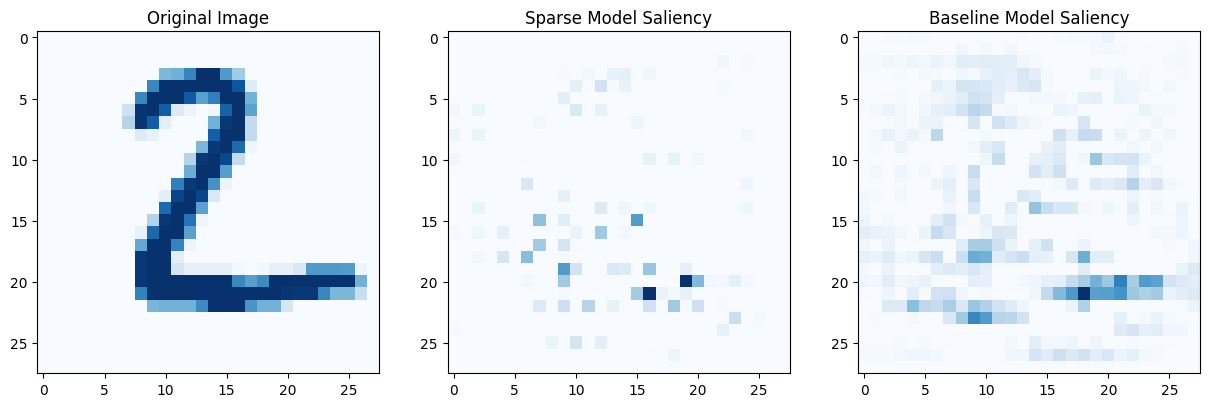

In [26]:
index = 1
img_saliency_sparse = backward_model.predict([x_test[index:index+1], y_test[index:index+1]])
img_saliency_baseline = backward_model_baseline.predict([x_test[index:index+1], y_test[index:index+1]])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(x_test[index,0], cmap='Blues')
ax1.set_title('Original Image')
ax2.imshow(np.clip(img_saliency_sparse[0,0], epsilon_grad, 100)-epsilon_grad, cmap='Blues')
ax2.set_title('Sparse Model Saliency')
ax3.imshow(np.clip(img_saliency_baseline[0,0], epsilon_grad, 100)-epsilon_grad, cmap='Blues')
ax3.set_title('Baseline Model Saliency')
plt.show()


In [33]:
# spread values
gradient_baseline = backward_model_baseline.predict([x_test, y_test], verbose=0)
sparse_baseline = (np.reshape(np.abs(gradient_baseline), (-1, 784)) > epsilon_grad).sum(-1)

print('less sparse, average non zero element is {} over 784 input features'.format(np.mean(sparse_baseline)))

less sparse, average non zero element is 733.0379 over 784 input features


In [34]:
# spread values
gradient_baseline = backward_model.predict([x_test, y_test], verbose=0)
sparse_baseline = (np.reshape(np.abs(gradient_baseline), (-1, 784)) > epsilon_grad).sum(-1)

print('less sparse, average non zero element is {} over 784 input features'.format(np.mean(sparse_baseline)))

less sparse, average non zero element is 259.684 over 784 input features


In [36]:
gradient_saliency_baseline = backward_model_baseline.predict([x_test, y_test], verbose=0)
# Separate the sparsity scores for correct and incorrect predictions
good_prediction_baseline = np.argmax(baseline_model.predict(x_test), -1) == np.argmax(y_test, -1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


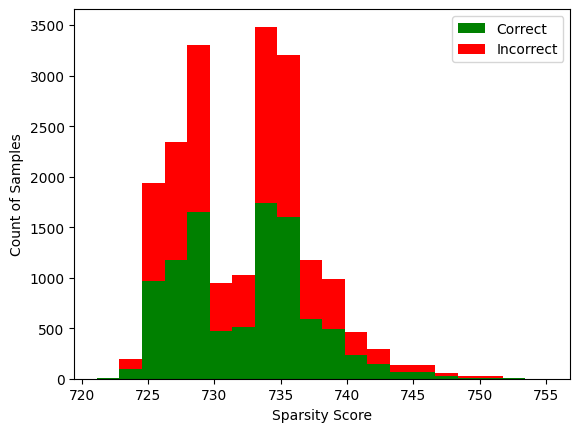

In [40]:
sparsity_scores_baseline = (np.reshape(np.abs(gradient_saliency_baseline), (-1, 784)) > 1e-4).sum(-1)
# Plot histogram of sparsity scores
n_bins = 20
bins_baseline = np.linspace(sparsity_scores_baseline.min(), sparsity_scores_baseline.max(), n_bins + 1)

pos_counts_baseline, _ = np.histogram(sparsity_scores_baseline[good_prediction_baseline], bins=bins_baseline)
neg_counts_baseline, _ = np.histogram(sparsity_scores_baseline[good_prediction_baseline], bins=bins_baseline)

plt.bar(bins_baseline[:-1], pos_counts_baseline, width=np.diff(bins_baseline), color='green', label='Correct')
plt.bar(bins_baseline[:-1], neg_counts_baseline, width=np.diff(bins_baseline), bottom=pos_counts_baseline, color='red', label='Incorrect')
plt.xlabel('Sparsity Score')
plt.ylabel('Count of Samples')
plt.legend()
plt.show()


## Conclusion
This tutorial demonstrated how to train a neural network with sparse gradient support using the Jacobinet library. By incorporating gradient sparsity constraints, we observed improvements in robustness, interpretability, and generalization.

### Key Takeaways
- Robustness and Interpretability: Sparse gradients prioritize the most critical features, naturally enhancing model robustness against adversarial attacks and improving explainability.
- Simple Implementation: Jacobinet makes it easy to introduce gradient sparsity constraints into a Keras training pipeline with minimal changes.
- Dynamic Sparsity: We showcased how to gradually increase the cardinality constraint during training, giving the model greater flexibility to adapt.
- Future Directions: Further exploration could focus on how different cardinality constraints affect robustness, how sparsity compares to L1 regularization, and how it influences resistance to adversarial attacks.

### Next Steps
To deepen your understanding, try experimenting with:

- Cardinality Adjustment: Vary the gradient cardinality constraint and observe how it affects sparsity, accuracy, and robustness.
- Visualization: Generate and compare saliency maps for sparse and non-sparse models.
- Adversarial Testing: Test the model's resistance to adversarial perturbations and analyze the impact of gradient sparsity on defense capabilities.
### Further Reading
If you're interested in the theoretical foundations of sparsity, robustness, and interpretability, here are some key resources:

* "Intriguing Properties of Neural Networks" by Szegedy et al. (2013) — A seminal paper that introduced the concept of adversarial robustness.
* "SmoothGrad: Removing Noise by Adding Noise" (2017) — A technique for generating clear and interpretable saliency maps for model explanations.
By exploring these topics, you'll gain a deeper understanding of how gradient sparsity can improve the robustness, interpretability, and efficiency of neural networks.
